# Projet 6 Openclassrooms
## Regaud Agnès

## Suite sujet : la mission n°2 est de réaliser une classification supervisée à partir des images. Il faudra mettre en place une data augmentation afin d’optimiser le modèle.
## Notebook 2 : Classification supervisée des images


# Préparation du dataset

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 1 Import des données

In [63]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/cleaned/'
filename = "df_image.csv"
data = pd.read_csv(path + filename)
data


Mounted at /content/drive


,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,HomeFurnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,BabyCare,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,BabyCare,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,HomeFurnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,HomeFurnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,BabyCare,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,BabyCare,0
1047,5912e037d12774bb73a2048f35a00009.jpg,BabyCare,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,BabyCare,0


## 1.1 Séparation des dataframes test et train

In [64]:
#Séparation données de test/entraînement
#Création du dataset_train:
sample1 = data.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=0))
sample1

,image_path,label_name,label
907,480d24adbc304a52a4e01e45bf8bbccc.jpg,BabyCare,0
632,96bc1fbb83ad5a2c0441d132fe8bcf97.jpg,BabyCare,0
448,750f964cf8e6a16412aaf2b0d0350d0a.jpg,BabyCare,0
793,fda0890dba67c93a7c80b0993651caec.jpg,BabyCare,0
74,7a3f11f380a1bf85338ab3771ff81e9f.jpg,BabyCare,0
...,...,...,...
496,087e83a2406dc98d941b8555356da477.jpg,Watches,6
10,920154acbe49d3202ed7d2ed2df1ea13.jpg,Watches,6
517,86b358a265312c139e5714e663daff05.jpg,Watches,6
790,75549ef6adc47e9b6dc2b69f530d9097.jpg,Watches,6


In [65]:
#Création du dataset_test
sample2 = data.copy()
list_index_del = sample1.index.to_list()
for idx, raw in sample2.iterrows() :
  if idx in list_index_del :
    sample2.drop(idx, inplace=True)
sample2

,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,HomeFurnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,BabyCare,0
5,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches,6
14,bbb8cdc5406ff60ff06ff64630f2ca47.jpg,Watches,6
19,33d97d63c037078cd3f08033966d6a88.jpg,Watches,6
...,...,...,...
1026,3f97735a6c61a3587cefceaef36c280c.jpg,HomeFurnishing,4
1028,9b805665a791f40e7946a73dcea17e35.jpg,Computers,2
1040,3b465b02720ef7c930cb2e065a8fc05d.jpg,BabyCare,0
1042,057836ecde71565f8ebdd576e41fdc96.jpg,BabyCare,0


In [66]:
#Renommage des 2 DF
sample1.reset_index(drop=True, inplace=True)
data = sample1
display(data)


sample2.reset_index(drop=True, inplace=True)
data_test = sample2
display(data_test)

,image_path,label_name,label
0,480d24adbc304a52a4e01e45bf8bbccc.jpg,BabyCare,0
1,96bc1fbb83ad5a2c0441d132fe8bcf97.jpg,BabyCare,0
2,750f964cf8e6a16412aaf2b0d0350d0a.jpg,BabyCare,0
3,fda0890dba67c93a7c80b0993651caec.jpg,BabyCare,0
4,7a3f11f380a1bf85338ab3771ff81e9f.jpg,BabyCare,0
...,...,...,...
730,087e83a2406dc98d941b8555356da477.jpg,Watches,6
731,920154acbe49d3202ed7d2ed2df1ea13.jpg,Watches,6
732,86b358a265312c139e5714e663daff05.jpg,Watches,6
733,75549ef6adc47e9b6dc2b69f530d9097.jpg,Watches,6


,image_path,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,HomeFurnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,BabyCare,0
2,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches,6
3,bbb8cdc5406ff60ff06ff64630f2ca47.jpg,Watches,6
4,33d97d63c037078cd3f08033966d6a88.jpg,Watches,6
...,...,...,...
310,3f97735a6c61a3587cefceaef36c280c.jpg,HomeFurnishing,4
311,9b805665a791f40e7946a73dcea17e35.jpg,Computers,2
312,3b465b02720ef7c930cb2e065a8fc05d.jpg,BabyCare,0
313,057836ecde71565f8ebdd576e41fdc96.jpg,BabyCare,0


## 1.2 Vérifications

In [67]:
#Vérifions la bonne répartition suivant les labels pour data et data_test:
data.groupby("label").count()

,image_path,label_name
label,,
0,105,105
1,105,105
2,105,105
3,105,105
4,105,105
5,105,105
6,105,105


In [68]:
data_test.groupby("label").count()

,image_path,label_name
label,,
0,45,45
1,45,45
2,45,45
3,45,45
4,45,45
5,45,45
6,45,45


In [69]:
#Vérification qu'il n'y a pas d'élément commun aux 2 dataframes:
if __name__ == '__main__':

    first = data_test['image_path'].to_list()
    second = data['image_path'].to_list()

    common = set(first).intersection(second)

    print(common)

set()


## 1.3 Séparations des images train/test par répertoire et par label

In [70]:
import shutil



#enregistrement des photos de data train et test par labels dans des dossiers :

def make_dir(directory) :
  if not os.path.exists(directory):
    os.mkdir(directory)

make_dir('/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_train/')
make_dir('/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_test/')


list_labels = data['label_name'].value_counts().index.to_list()


for label in list_labels :
  #création de répertoire :
  make_dir('/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_train/'+label+'/')

  data_label = data[data['label_name'] == label]
  for idx,raw in data_label.iterrows() :
    image = raw['image_path']
    src = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/Images/'+image
    dest = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_train/'+label+'/'
    shutil.copy2(src, dest)
    data.loc[data['image_path'] == image, 'image_path'] = dest+image






for label in list_labels :
  #création de répertoire :
  make_dir('/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_test/'+label+'/')
  data_label_test = data_test[data_test['label_name'] == label]
  for idx,raw in data_label_test.iterrows() :
    image = raw['image_path']
    src = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/Images/'+image
    dest = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_test/'+label+'/'
    shutil.copy2(src, dest)
    data_test.loc[data_test['image_path'] == image, 'image_path'] = dest+image


In [71]:
#enregistrement des 2 dataframes avec chemins vers les photos
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/data.csv'
path_test = '/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/data_test.csv'
data.to_csv(path, index=False)
data_test.to_csv(path_test, index=False)

Mounted at /content/drive


# 2 Classification supervisée des images
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


Data

In [72]:
data

,image_path,label_name,label
0,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
1,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
2,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
3,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
4,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
...,...,...,...
730,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6
731,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6
732,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6
733,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6


In [73]:
data_test

,image_path,label_name,label
0,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,HomeFurnishing,4
1,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
2,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6
3,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6
4,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Watches,6
...,...,...,...
310,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,HomeFurnishing,4
311,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,Computers,2
312,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0
313,/content/drive/MyDrive/Colab Notebooks/OC/Proj...,BabyCare,0


## 2.1 Approche simple


### a) Création du modèle de classification

In [74]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


### b) Approche préparation initiale des images

In [75]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(735, 224, 224, 3)
(315, 224, 224, 3)


In [76]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(551, 224, 224, 3)

In [78]:
y_train.shape

(551, 7)

In [79]:
# Création du modèle
import time
temps1=time.time()

with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

duration_simple=time.time()-temps1
print("Temps de création du modèle simple : ", "%15.2f" % duration_simple, "secondes")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [80]:
# Entraîner sur les données d'entraînement (X_train, y_train)
import time
temps1=time.time()

with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

duration_simple_entr=time.time()-temps1
print("Temps d'entraînement : ", "%15.2f" % duration_simple_entr, "secondes")



Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 5.9564 - accuracy: 0.4192
Epoch 1: val_loss improved from inf to 1.69186, saving model to ./model1_best_weights.h5
9/9 [==============================] - 3s 189ms/step - loss: 5.9564 - accuracy: 0.4192 - val_loss: 1.6919 - val_accuracy: 0.7283
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - ETA: 0s - loss: 2.3149 - accuracy: 0.6080
Epoch 2: val_loss improved from 1.69186 to 1.47454, saving model to ./model1_best_weights.h5
9/9 [==============================] - 1s 130ms/step - loss: 2.3149 - accuracy: 0.6080 - val_loss: 1.4745 - val_accuracy: 0.7554
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 1.6457 - accuracy: 0.7132
Epoch 3: val_loss improved from 1.47454 to 1.11006, saving model to ./model1_best_weights.h5
9/9 [==============================] - 1s 128ms/step - loss: 1.6457 - accuracy: 0.7132 - val_loss: 1.1101 - val_accuracy: 0.7391
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.8131
Epoch 4: val_loss improved from 1.11006 to 1.02619, saving model to ./model1_best_weights.h5
9/9 [==============================] - 1s 133ms/step - loss: 0.9634 - accuracy: 0.8131 - val_loss: 1.0262 - val_accuracy: 0.7772
Epoch 5/50
9/9 [==============================] - ETA: 0s - loss: 0.7

### c) Score du dernier epoch

In [81]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

18/18 [==============================] - 1s 41ms/step - loss: 0.0089 - accuracy: 1.0000
Training Accuracy: 1.0000

6/6 [==============================] - 0s 41ms/step - loss: 1.0639 - accuracy: 0.7772
Validation Accuracy:  0.7772


### d)Score de l'epoch optimal

In [82]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy_val_vgg = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_vgg))

loss, accuracy_test_vgg = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_vgg))


Validation Accuracy :  0.7989
Test Accuracy       :  0.8222


In [83]:
!pip install plot_keras_history

### e) Résultats loss et accuracy

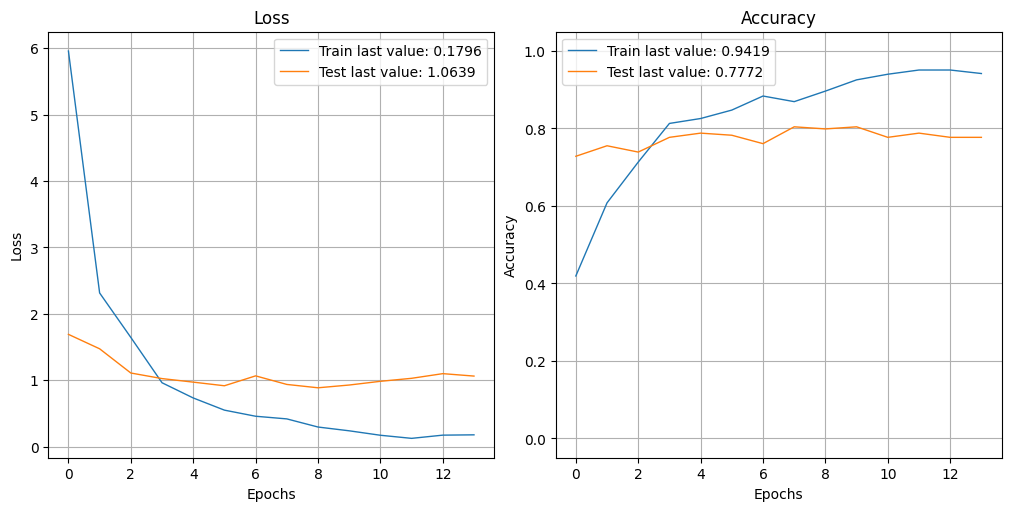

In [84]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [85]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 0s 40ms/step
[3 3 2 0 1 1 2 5 0 6 2 5 3 1 2 1 4 3 4 3 5 3 4 5 5 5 5 2 0 1 3 4 0 3 3 3 4
 3 4 6 4 6 5 1 1 3 6 3 4 6 3 4 6 2 0 1 6 1 2 1 6 1 0 6 3 0 5 0 1 1 1 5 2 4
 6 2 2 5 6 5 1 0 1 5 4 6 1 2 3 3 4 1 4 4 0 3 0 2 5 4 4 0 0 4 1 2 0 3 5 0 0
 0 0 6 6 1 6 0 5 0 5 4 2 4 2 6 4 5 1 0 6 1 5 4 5 0 2 2 3 4 2 6 5 5 3 5 3 0
 1 4 4 0 3 2 5 1 6 6 3 6 5 6 6 2 2 2 4 2 0 3 6 2 3 3 0 4 1 0 5 6 6 1 2 2]

[3 5 3 0 1 1 2 3 4 6 2 5 3 1 2 1 4 3 4 3 5 3 3 5 5 5 5 2 0 1 3 4 3 3 3 3 4
 3 4 6 4 6 5 1 6 3 6 3 0 6 3 4 6 2 3 3 6 4 2 1 6 1 0 6 3 4 5 3 1 1 1 5 2 4
 6 2 2 5 6 5 1 4 1 5 3 1 1 3 3 1 4 1 0 4 0 3 0 2 5 4 4 3 2 4 1 3 0 3 5 0 0
 4 4 6 6 1 2 0 5 3 5 4 2 4 1 6 4 5 1 0 6 1 5 4 5 0 2 2 3 4 2 6 5 2 3 5 3 0
 1 4 4 0 3 2 5 5 2 6 0 3 5 6 6 5 2 2 4 2 0 2 6 1 3 1 0 4 2 0 5 6 6 1 2 2]


In [86]:
from sklearn import cluster, metrics
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[16  0  1  5  5  0  0]
 [ 0 21  1  1  1  1  1]
 [ 0  2 20  3  0  1  0]
 [ 1  2  1 22  0  1  0]
 [ 2  0  0  2 22  0  0]
 [ 0  0  1  1  0 24  0]
 [ 0  1  2  1  0  0 22]]


In [87]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [88]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[16  0  1  5  5  0  0]
 [ 0 21  1  1  1  1  1]
 [ 0  2 20  3  0  1  0]
 [ 1  2  1 22  0  1  0]
 [ 2  0  0  2 22  0  0]
 [ 0  0  1  1  0 24  0]
 [ 0  1  2  1  0  0 22]]

              precision    recall  f1-score   support

           0       0.84      0.59      0.70        27
           1       0.81      0.81      0.81        26
           2       0.77      0.77      0.77        26
           3       0.63      0.81      0.71        27
           4       0.79      0.85      0.81        26
           5       0.89      0.92      0.91        26
           6       0.96      0.85      0.90        26

    accuracy                           0.80       184
   macro avg       0.81      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184



<Axes: >

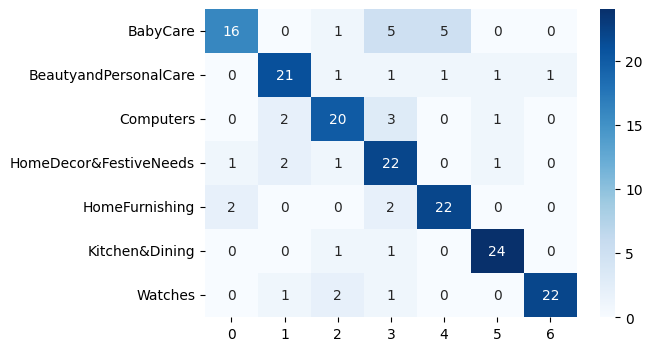

In [89]:
list_labels = data['label_name'].value_counts().index.to_list()
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "BabyCare" sont désormais bien affectées à "BabyCare" et non pas "Watches"

# 3 Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [91]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [92]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [93]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 552 validated image filenames belonging to 7 classes.
Found 183 validated image filenames belonging to 7 classes.
Found 315 validated image filenames belonging to 7 classes.


### a) Création du modèle

In [94]:
# Création du modèle
temps1=time.time()

with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

duration_idg =time.time()-temps1
print("Temps de création modèle ImageDatagenerator : ", "%15.2f" % duration_idg, "secondes")



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [95]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [96]:
#Entraînement modèle
temps1=time.time()

with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

duration_idg_entr=time.time()-temps1
print("Temps d'entraînement ImageDatagenrator' : ", "%15.2f" % duration_idg_entr, "secondes")

Epoch 1/50
 8/18 [============>.................] - ETA: 9s - loss: 5.4518 - accuracy: 0.3477

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


18/18 [==============================] - ETA: 0s - loss: 4.0611 - accuracy: 0.4312
Epoch 1: val_loss improved from inf to 1.56311, saving model to ./model2_best_weights.h5
18/18 [==============================] - 24s 1s/step - loss: 4.0611 - accuracy: 0.4312 - val_loss: 1.5631 - val_accuracy: 0.7104
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 1.6211 - accuracy: 0.6486
Epoch 2: val_loss improved from 1.56311 to 1.56026, saving model to ./model2_best_weights.h5
18/18 [==============================] - 20s 1s/step - loss: 1.6211 - accuracy: 0.6486 - val_loss: 1.5603 - val_accuracy: 0.7268
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.1483 - accuracy: 0.7264
Epoch 3: val_loss improved from 1.56026 to 1.48127, saving model to ./model2_best_weights.h5
18/18 [==============================] - 21s 1s/step - loss: 1.1483 - accuracy: 0.7264 - val_loss: 1.4813 - val_accuracy: 0.7322
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.7923 - accuracy: 0.7663
Epoch 4: val_loss improved from 1.48127 to 1.04122, saving model to ./model2_best_weights.h5
18/18 [==============================] - 20s 1s/step - loss: 0.7923 - accuracy: 0.7663 - val_loss: 1.0412 - val_accuracy: 0.7814
Epoch 5/50
18/18 [==============================] - ETA: 0s - l

### b) Score du dernier epoch

In [97]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 15s 848ms/step - loss: 0.1012 - accuracy: 0.9674
Training Accuracy   : 0.9674

6/6 [==============================] - 5s 741ms/step - loss: 1.1001 - accuracy: 0.7596
Validation Accuracy :  0.7596


### c) Score de l'epoch optimal

In [98]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy_val_idg = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_idg))

loss, accuracy_test_idg = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_idg))


Validation Accuracy :  0.7541
Test Accuracy       :  0.8000


### d) Résultats loss et accuracy

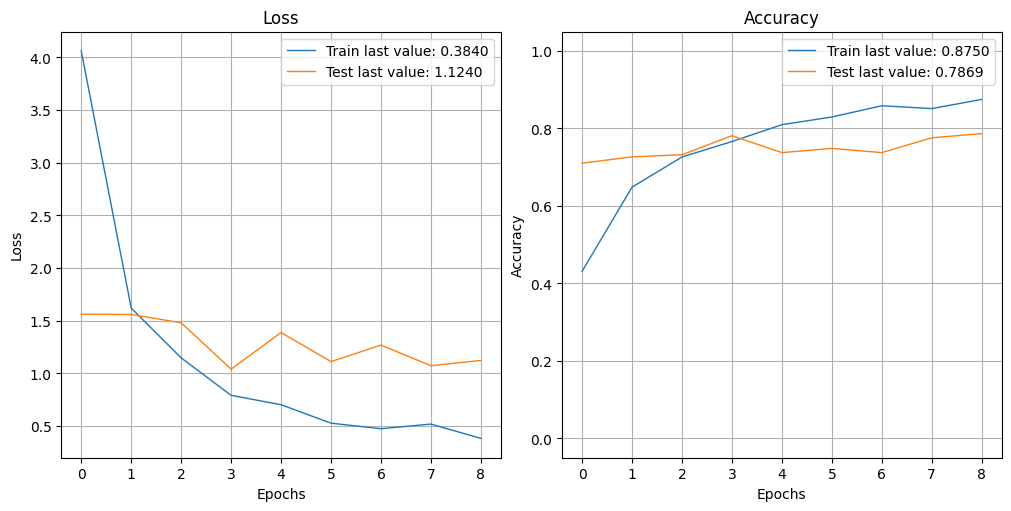

In [99]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

# 4 Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [100]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [101]:
path = "/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_train/"
path_test = "/content/drive/MyDrive/Colab Notebooks/OC/Projet 6/source/dataset_test/"
data_path = glob(path+'*/*.jp*')
data_test_path = glob(path_test+'*/*.jp*')

dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


### a) Création du modèle

In [102]:
# Création du modèle
temps1=time.time()

with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

duration_sda=time.time()-temps1
print("Temps de création modèle par dataset sans data augmentation : ", "%15.2f" % duration_sda, "secondes")



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [103]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [104]:
#Entraînement modèle:
temps1=time.time()

with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

duration_sda_entr=time.time()-temps1
print("Temps d'entraînement modèle par dataset sans data augmentation': ", "%15.2f" % duration_sda_entr, "secondes")

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 6.3359 - accuracy: 0.4449
Epoch 1: val_loss improved from inf to 1.53428, saving model to ./model3_best_weights.h5
18/18 [==============================] - 6s 170ms/step - loss: 6.2465 - accuracy: 0.4511 - val_loss: 1.5343 - val_accuracy: 0.7432
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/18 [===========================>..] - ETA: 0s - loss: 2.3870 - accuracy: 0.6654
Epoch 2: val_loss improved from 1.53428 to 1.29781, saving model to ./model3_best_weights.h5
18/18 [==============================] - 4s 169ms/step - loss: 2.3823 - accuracy: 0.6667 - val_loss: 1.2978 - val_accuracy: 0.7650
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 1.5879 - accuracy: 0.7298
Epoch 3: val_loss did not improve from 1.29781
18/18 [==============================] - 4s 168ms/step - loss: 1.6078 - accuracy: 0.7283 - val_loss: 1.4306 - val_accuracy: 0.7432
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 1.0764 - accuracy: 0.7684
Epoch 4: val_loss improved from 1.29781 to 1.09687, saving model to ./model3_best_weights.h5
18/18 [==============================] - 4s 165ms/step - loss: 1.0734 - accuracy: 0.7699 - val_loss: 1.0969 - val_accuracy: 0.8087
Epoch 5/50
17/18 [===========================>..] - ETA: 0s - loss: 0.7103 - accuracy: 0.8088
Epoch 5: 

### b) Score du dernier epoch

In [105]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 3s 92ms/step - loss: 0.0164 - accuracy: 0.9946
Training Accuracy   : 0.9946

6/6 [==============================] - 1s 42ms/step - loss: 0.9528 - accuracy: 0.8361
Validation Accuracy :  0.8361


### c) Score de l'epoch optimal

In [106]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy_val_sans_da = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_sans_da))

loss, accuracy_test_sans_da = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_sans_da))


Validation Accuracy :  0.8415
Test Accuracy       :  0.8317


### d) Résultats loss et accuracy

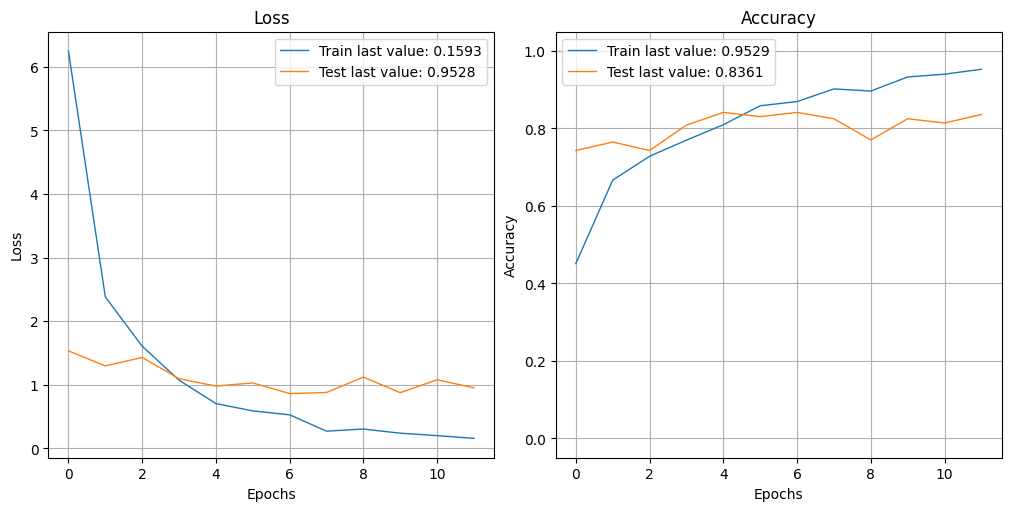

In [107]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

# 5 Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [108]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [109]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 735 files belonging to 7 classes.
Using 552 files for training.
Found 735 files belonging to 7 classes.
Using 183 files for validation.
Found 315 files belonging to 7 classes.


In [110]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



### a) Création du modèle

In [111]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


In [112]:
# Création du modèle
temps1=time.time()

with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


duration_da=time.time()-temps1
print("Temps de création modèle par dataset avec data augmentation intégrée : ", "%15.2f" % duration_da, "secondes")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [113]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [114]:
#Entraînement du modèle :
temps1=time.time()

with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

duration_da_entr=time.time()-temps1
print("Temps d'entraînement du modèle par dataset avec data augmentation intégrée : ", "%15.2f" % duration_da_entr, "secondes")

Epoch 1/50
17/18 [===========================>..] - ETA: 0s - loss: 1.9213 - accuracy: 0.2463
Epoch 1: val_loss improved from inf to 1.45130, saving model to ./model4_best_weights.h5
18/18 [==============================] - 6s 176ms/step - loss: 1.9145 - accuracy: 0.2464 - val_loss: 1.4513 - val_accuracy: 0.6940
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/18 [===========================>..] - ETA: 0s - loss: 1.4507 - accuracy: 0.5000
Epoch 2: val_loss improved from 1.45130 to 1.21426, saving model to ./model4_best_weights.h5
18/18 [==============================] - 4s 167ms/step - loss: 1.4476 - accuracy: 0.5018 - val_loss: 1.2143 - val_accuracy: 0.6721
Epoch 3/50
17/18 [===========================>..] - ETA: 0s - loss: 1.2677 - accuracy: 0.5827
Epoch 3: val_loss improved from 1.21426 to 0.99934, saving model to ./model4_best_weights.h5
18/18 [==============================] - 4s 170ms/step - loss: 1.2703 - accuracy: 0.5797 - val_loss: 0.9993 - val_accuracy: 0.7541
Epoch 4/50
17/18 [===========================>..] - ETA: 0s - loss: 1.1367 - accuracy: 0.6342
Epoch 4: val_loss improved from 0.99934 to 0.88608, saving model to ./model4_best_weights.h5
18/18 [==============================] - 4s 178ms/step - loss: 1.1374 - accuracy: 0.6322 - val_loss: 0.8861 - val_accuracy: 0.7978
Epoch 5/50
17/18 [===========================>..] - ETA: 

### b) Score du dernier epoch

In [115]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

18/18 [==============================] - 3s 91ms/step - loss: 0.2710 - accuracy: 0.9076
Training Accuracy   : 0.9076

6/6 [==============================] - 1s 41ms/step - loss: 0.6180 - accuracy: 0.8142
Validation Accuracy :  0.8142


### c) Score de l'epoch optimal

In [116]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy_val_dai = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_dai))

loss, accuracy_test_dai = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_dai))


Validation Accuracy :  0.8470
Test Accuracy       :  0.8349


### d) Résultats loss et accuracy

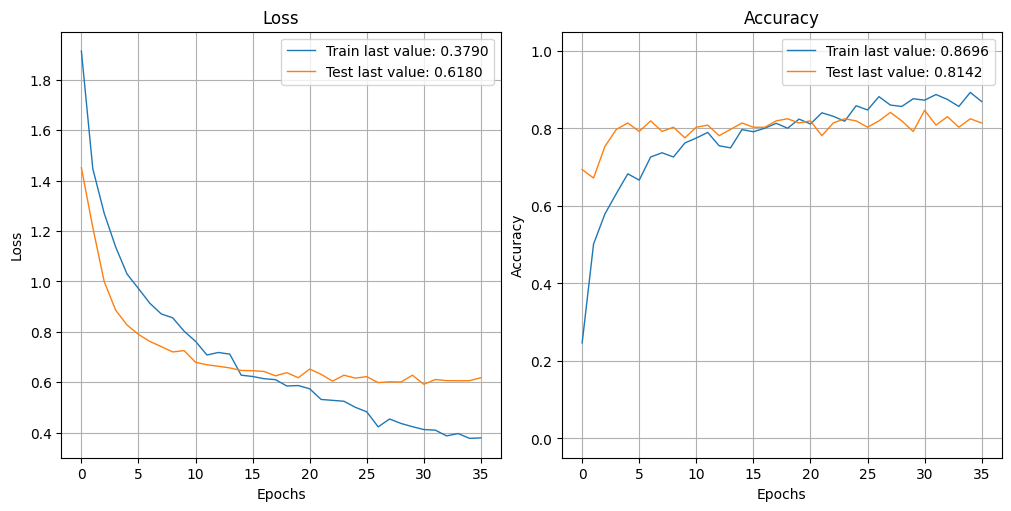

In [117]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# 5 Scores epoch optimaux des différents modèles avec temps

In [118]:
df_opti = pd.DataFrame()

4 modèles testés :


1.   VGG16 : Simple VGG16,
2.   IDG : ImageDatagenerator
3.   SansDA : Par dataset sans data augmentation,
4.   DAIntégrée : Par dataset avec data augmentation intégrée

In [119]:
df_opti['Modèle'] = ['VGG16', 'IDG', 'SansDA', 'DAIntégrée']
df_opti['Validation Accuracy'] = [accuracy_val_vgg, accuracy_val_idg, accuracy_val_sans_da, accuracy_val_dai]
df_opti['Test Accuracy'] = [accuracy_test_vgg, accuracy_test_idg, accuracy_test_sans_da, accuracy_test_dai]
df_opti['Temps de création du modèle en secondes'] = [duration_simple, duration_idg, duration_sda, duration_da]
df_opti["Temps d'entraînement du modèle en secondes"] = [duration_simple_entr, duration_idg_entr, duration_sda_entr, duration_da_entr]
print('Scores epoch optimal pour chaque modèle testé :')
df_opti

Scores epoch optimal pour chaque modèle testé :


,Modèle,Validation Accuracy,Test Accuracy,Temps de création du modèle en secondes,Temps d'entraînement du modèle en secondes
0,VGG16,0.798913,0.822222,0.462533,17.016821
1,IDG,0.754098,0.800000,0.445700,186.266010
2,SansDA,0.841530,0.831746,0.447957,49.726068
3,DAIntégrée,0.846995,0.834921,0.767045,148.539452
